In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import sys, os
import keras
import cv2
import traceback

from IPython.display import display, Image, Markdown
import pandas as pd
import numpy as np
from src.keras_utils import load_model
from glob import glob
from os.path import splitext, basename
from src.utils import im2single
from src.keras_utils import load_model, detect_lp
from src.label import Shape, writeShapes, Label

import matplotlib.pyplot as plt
from src.label import dknet_label_conversion
from src.utils import nms
from tqdm import tqdm

In [4]:
os.environ['DARKNET_PATH'] = os.getcwd() + "/darknetlib/"

In [5]:
import darknet.darknet as dn
from darknet.darknet import detect_image

In [6]:
import pytesseract

In [7]:
tqdm.pandas()

In [8]:
lp_threshold = .5

In [9]:
ocr_threshold = .4

In [10]:
wpod_net_path = "models/my-trained-model/my-trained-model_backup.h5"
wpod_net = load_model(wpod_net_path)

In [11]:
ocr_weights = 'data/ocr/ocr-net.weights'
ocr_netcfg  = 'data/ocr/ocr-net.cfg'
ocr_dataset = 'data/ocr/ocr-net.data'

In [12]:
network, class_names, class_colors = dn.load_network(ocr_netcfg, ocr_dataset, ocr_weights)

In [13]:
ocr_net  = dn.load_net(ocr_netcfg.encode("ascii"), ocr_weights.encode("ascii"), 0)
ocr_meta = dn.load_meta(ocr_dataset.encode("ascii"))

In [14]:
def format_pl(L):
    l_highest = min(L, key=lambda x: x.tl()[1])
    first_line = []
    second_line = []
    y_threshold = (l_highest.bl()[1] - l_highest.tl()[1]) / 2
    for l in L:
        if l.tl()[1] - l_highest.tl()[1] < y_threshold:
            first_line.append(l)
        else:
            second_line.append(l)
    first_line.sort(key=lambda x: x.tl()[0])
    second_line.sort(key=lambda x: x.tl()[0])    
    license_plate_str = "".join([chr(i.cl()) for i in first_line])
    if len(second_line) > 0:  # if license plate has 2 lines
        license_plate_str += "-" + "".join([chr(i.cl()) for i in second_line])
    return license_plate_str

In [15]:
def lp_detect(img_path, debug=False, ocr_mode="darknet"):
    if debug:
        print(img_path)
    bname = splitext(basename(img_path))[0]
    Ivehicle = cv2.imread(img_path)
    if debug:
        display(Image(img_path))
    ratio = float(max(Ivehicle.shape[:2]))/min(Ivehicle.shape[:2])
    side  = int(ratio*288.)
    bound_dim = min(side + (side%(2**4)),608)
    if debug:
        print("\t\tBound dim: %d, ratio: %f" % (bound_dim,ratio))
    Llp, LlpImgs, _ = detect_lp(wpod_net,im2single(Ivehicle),bound_dim,2**4,(240,80),lp_threshold)
    license_plate_str = None
    if len(LlpImgs):
        Ilp = LlpImgs[0]
        Ilp = cv2.cvtColor(Ilp, cv2.COLOR_BGR2GRAY)
        if debug:
            plt.imshow(Ilp)
            plt.show()
        
        if ocr_mode == "tesseract":
            binary = cv2.GaussianBlur(Ilp, (5, 5), 0)
            if debug:
                plt.imshow(binary)
                plt.show()
            license_plate_str = pytesseract.image_to_string(binary, lang ='eng', config ='--psm 7')
        else:
            Ilp = cv2.cvtColor(Ilp, cv2.COLOR_GRAY2BGR)

            pl_path = '%s/%s_lp.png' % ("tmp", bname)

            cv2.imwrite(pl_path, Ilp*255.)
            
            width = dn.network_width(network)
            height = dn.network_height(network)
            darknet_image = dn.make_image(width, height, 3)
            image_resized = cv2.imread(pl_path)
            dn.copy_image_from_bytes(darknet_image, image_resized.tobytes())
            
            R = detect_image(network, class_names, darknet_image,thresh=ocr_threshold, nms=None)
            dim = Ilp.shape[:2]
            os.remove(pl_path)
            if len(R):
                L = dknet_label_conversion(R,width,height)
                L = nms(L,.45)
                license_plate_str = format_pl(L)
                if debug:
                    print('\t\tLP: %s' % license_plate_str)
            else:
                if debug:
                    print('No characters found')
    if debug:
        display(Markdown("---"))
    return license_plate_str

../../data/test/test.jpg


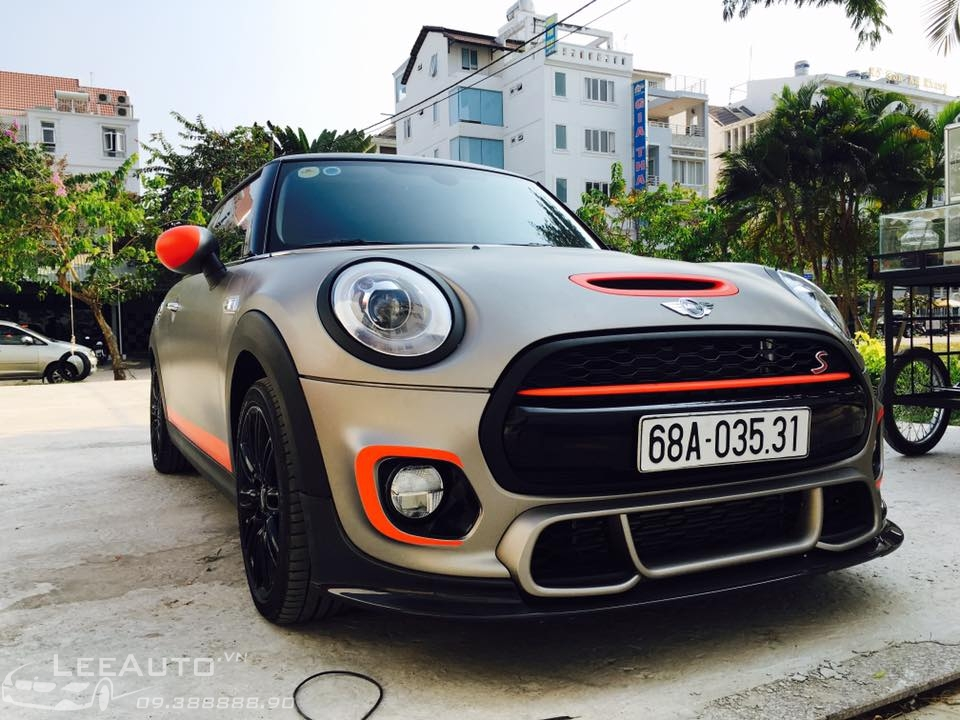

		Bound dim: 384, ratio: 1.333333


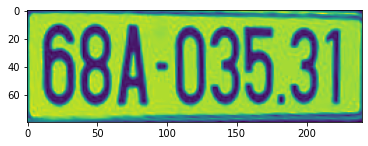

		LP: 68A03531


---

CPU times: user 8.73 s, sys: 12.7 s, total: 21.4 s
Wall time: 1.97 s


'68A03531'

In [16]:
%%time
lp_detect("../../data/test/test.jpg", debug=True)